Saved as Original Image.jpg
Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB

Time Taken: 81.921982
Saved as SRGANOP.jpg


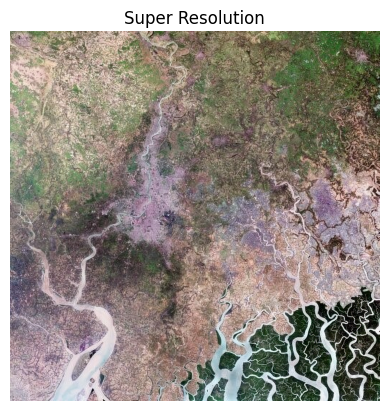

In [ ]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

# Declaring Constants
path1 = "low.jpg"
path2 = path1
IMAGE_PATH = path1
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

  %matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

hr_image = preprocess_image(IMAGE_PATH)
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

model = hub.load(SAVED_MODEL_PATH)
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="SRGANOP")



(2048, 2048)
(2048, 2048)


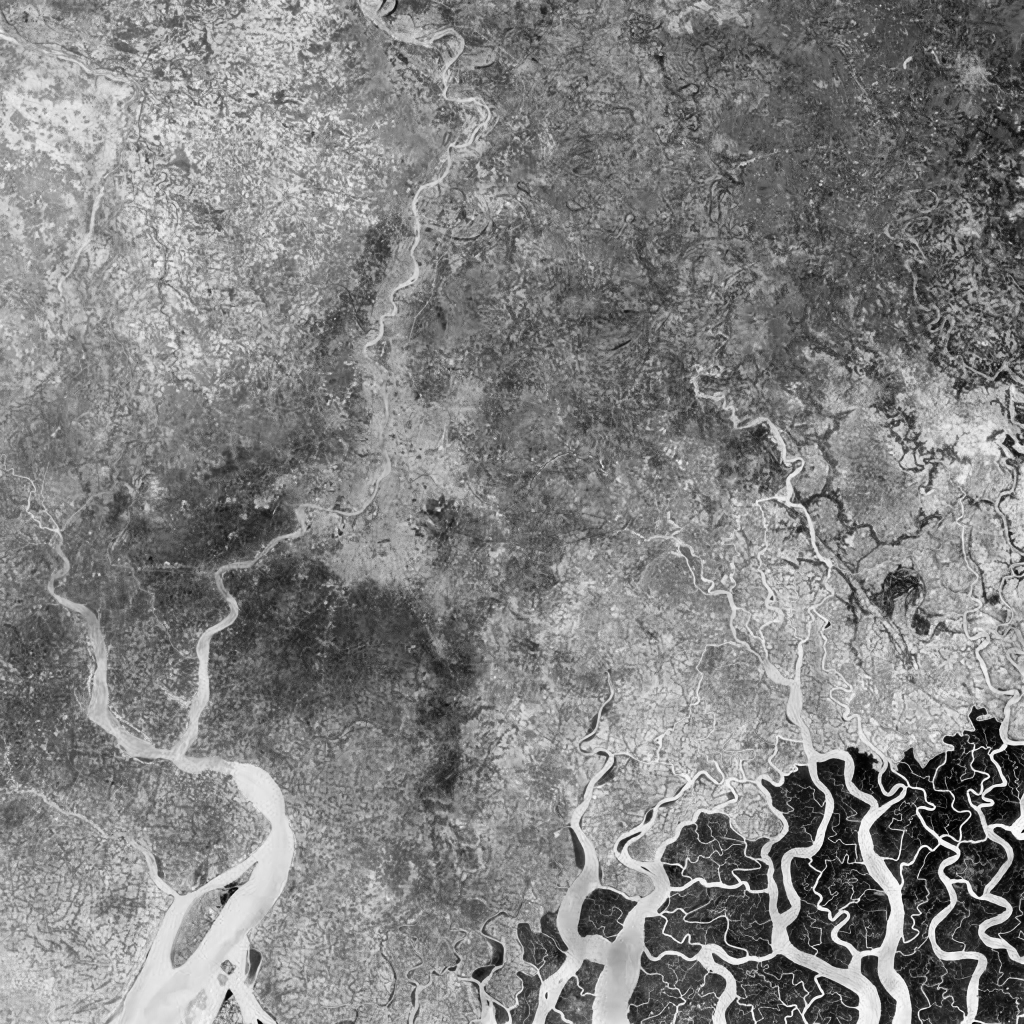

(1024, 1024)
Structural Similarity Index with Image 1:  0.91887092319934
Mean Squared Error with Image 1:  82.00253963470459
Structural Similarity Index with Image 2:  0.9141076453349589
Mean Squared Error with Image 2:  77.92541027069092


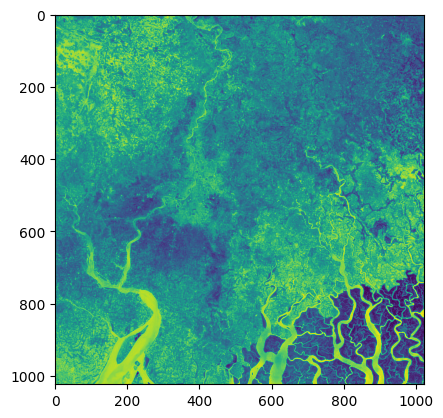

In [ ]:
from os import environ
environ["OPENCV_IO_ENABLE_JASPER"] = "true"
environ['OPENCV_IO_ENABLE_JASPER'] = '1'
import os
import pywt
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.metrics import structural_similarity as ssim
from google.colab.patches import cv2_imshow

#directory = r'/*path*/'
#os.chdir(directory)
def fuseCoeff(cooef1, cooef2, method):
    if (method == 'mean'):
        cooef = (cooef1 + cooef2) / 2
    elif (method == 'min'):
        cooef = np.minimum(cooef1,cooef2)
    elif (method == 'max'):
        cooef = np.maximum(cooef1,cooef2)
    else:
        cooef = []
    return cooef

FUSION_METHOD = 'mean'
I1 = cv2.imread('high.jpg',0)
I2 = cv2.imread('SRGANOP.jpg',0)
print(I1.shape)
print(I2.shape)
wavelet = 'db1'
cooef1 = pywt.wavedec2(I1[:,:], wavelet)
cooef2 = pywt.wavedec2(I2[:,:], wavelet)
fusedCooef = []

for i in range(len(cooef1)-1):
    if(i == 0):
        fusedCooef.append(fuseCoeff(cooef1[0],cooef2[0],FUSION_METHOD))
    else:
        c1 = fuseCoeff(cooef1[i][0],cooef2[i][0],FUSION_METHOD)
        c2 = fuseCoeff(cooef1[i][1], cooef2[i][1], FUSION_METHOD)
        c3 = fuseCoeff(cooef1[i][2], cooef2[i][2], FUSION_METHOD)
        fusedCooef.append((c1,c2,c3))
fusedImage = pywt.waverec2(fusedCooef, wavelet)
fusedImage = np.multiply(np.divide(fusedImage -
np.min(fusedImage),(np.max(fusedImage) - np.min(fusedImage))),255)
fusedImage = fusedImage.astype(np.uint8)
plt.imshow(fusedImage)
cv2.imwrite('fusedimagewavelet-srgan.jpg',fusedImage)
cv2_imshow(fusedImage)
cv2.waitKey(0)

#we perform analysis on input image 1 and output image.
#similarly on input image 2 and output image
#first we resize the input images with respect to output images
print(fusedImage.shape)
I1 = cv2.resize(I1,fusedImage.shape)
I2 = cv2.resize(I2,fusedImage.shape)
# fusedImage = cv2.resize(fusedImage,I1.shape)
#print(fusedImage.shape)
s1= ssim(fusedImage,I1)
print("Structural Similarity Index with Image 1: ",s1)
#mean squared error
err = np.sum((fusedImage.astype("float") - I1.astype("float")) ** 2)
err /= float(fusedImage.shape[0] * fusedImage.shape[1])
mse1=err
print("Mean Squared Error with Image 1: ",mse1)
#for input image2 and output image
#structural similarity index
s2= ssim(fusedImage,I2)
print("Structural Similarity Index with Image 2: ",s2)
#mean squared error
err = np.sum((fusedImage.astype("float") - I2.astype("float")) ** 2)
err /= float(fusedImage.shape[0] * fusedImage.shape[1])
mse2=err
print("Mean Squared Error with Image 2: ",mse2)

(2048, 2048)
(2048, 2048)
(2048, 2000)
(2048, 2000)


/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


Structural Similarity Index with Image 1:  0.850980999924422
Mean Squared Error with Image 1:  4764.060878831133
Structural Similarity Index with Image 2:  0.5024692042883792
Mean Squared Error with Image 2:  5616.378103676107


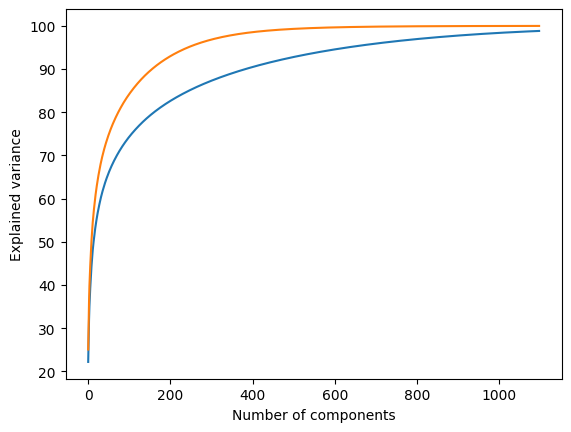

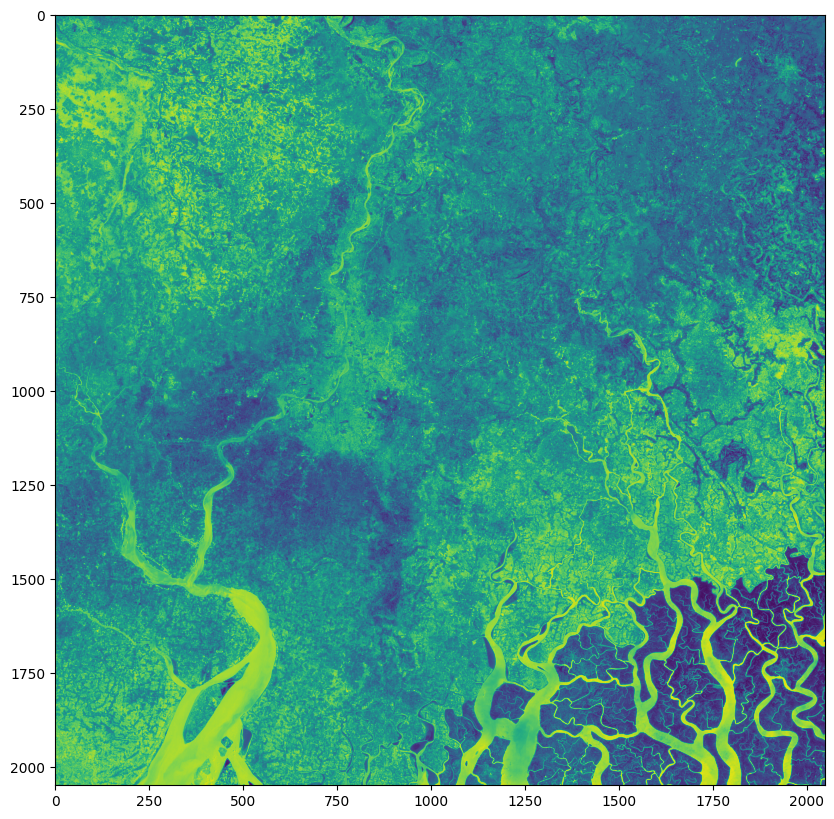

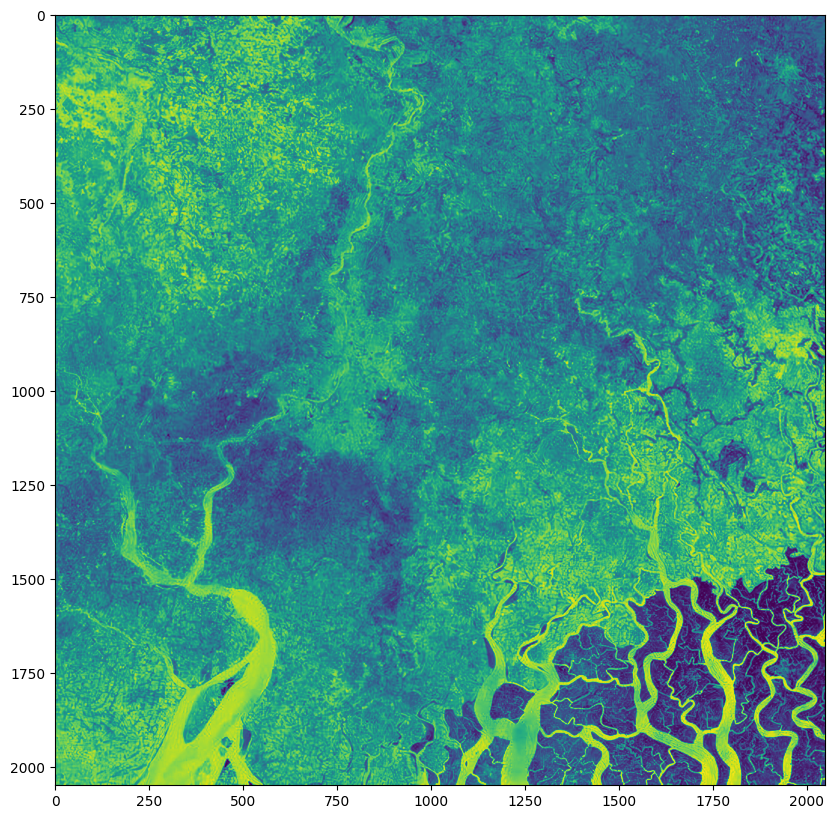

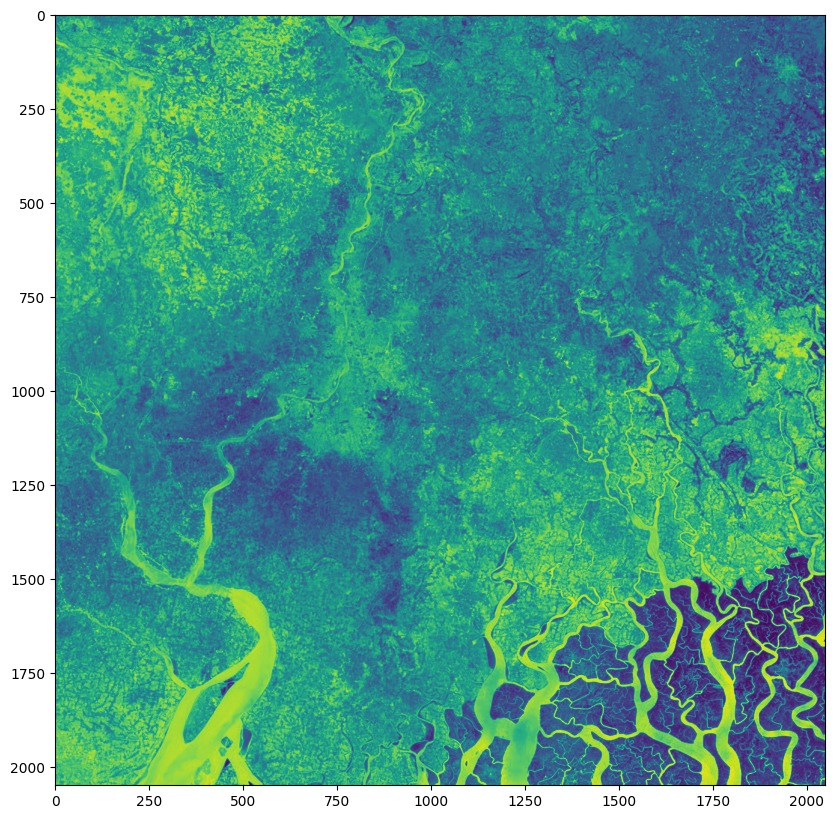

In [ ]:
import os
import pywt
from os import environ
environ["OPENCV_IO_ENABLE_JASPER"] = "true"
environ['OPENCV_IO_ENABLE_JASPER'] = '1'
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.metrics import structural_similarity as ssim
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

I1 = cv2.imread('high.jpg',0)
I2 = cv2.imread('SRGANOP.jpg',0)
I2 = cv2.resize(I2,I1.shape)
print(I1.shape)
print(I2.shape)

pca_1098= PCA(n_components=1098)
pca_1098.fit(I1)
plt.grid()
plt.plot(np.cumsum(pca_1098.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.savefig('Scree plot.jpg')


pca_1098_= PCA(n_components=1098)
pca_1098_.fit(I2)
plt.grid()
plt.plot(np.cumsum(pca_1098_.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.savefig('Scree plot.jpg')

pca =PCA(2000) # we need 200 principal components.
pca_=PCA(2000)
pca.fit(I2)
pca_.fit(I2)
converted_data = pca.transform(I1)
converted_data_ = pca.fit_transform(I2)
print(converted_data.shape)
print(converted_data_.shape)

i1 = pca.inverse_transform(converted_data)
plt.figure(figsize = (20,10))
plt.imshow(i1)
plt.savefig('pcatranformed_img.jpg')

i2 = pca_.inverse_transform(converted_data_)
plt.figure(figsize = (20,10))
plt.imshow(i2)
plt.savefig('pca_tranformed_img.jpg')

fusion_img=i1+i2/2
plt.figure(figsize = (20,10))
plt.imshow(fusion_img)
plt.savefig('pca_fusion_img.jpg')
cv2.imwrite('pcafusedimaget5-srgan.jpg',fusion_img)

#we perform analysis on input image 1 and output image.
#similarly on input image 2 and output image
#first we resize the input images with respect to output images
I1 = cv2.resize(I1,fusion_img.shape)
I2 = cv2.resize(I2,fusion_img.shape)
s1= ssim(fusion_img,I1)
print("Structural Similarity Index with Image 1: ",s1)
#mean squared error
err = np.sum((fusion_img.astype("float") - I1.astype("float")) ** 2)
err /= float(fusion_img.shape[0] * fusion_img.shape[1])
mse1=err
print("Mean Squared Error with Image 1: ",mse1)
#for input image2 and output image
#structural similarity index
s2= ssim(fusion_img,I2)
print("Structural Similarity Index with Image 2: ",s2)
#mean squared error
err = np.sum((fusion_img.astype("float") - I2.astype("float")) ** 2)
err /= float(fusion_img.shape[0] * fusion_img.shape[1])
mse2=err
print("Mean Squared Error with Image 2: ",mse2)